In [2]:
# import objects
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [4]:
# read file
data_set = pd.read_csv('impeachment-polls.csv')

In [5]:
# inspect data
type(data_set)
data_set.head()
data_set.describe()
data_set.dtypes
print(data_set.shape)
data_set.info() #count non-null values in the columns
data_set.isnull().sum(axis=0) #count blanks in the columns

(550, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 24 columns):
Start         550 non-null object
End           550 non-null object
Pollster      550 non-null object
Sponsor       283 non-null object
SampleSize    550 non-null int64
Pop           550 non-null object
tracking      114 non-null object
Text          549 non-null object
Category      549 non-null object
Include?      550 non-null object
Yes           550 non-null float64
No            550 non-null float64
Unsure        529 non-null float64
Rep Sample    483 non-null float64
Rep Yes       517 non-null float64
Rep No        500 non-null float64
Dem Sample    485 non-null float64
Dem Yes       523 non-null float64
Dem No        499 non-null float64
Ind Sample    417 non-null float64
Ind Yes       455 non-null float64
Ind No        438 non-null float64
URL           549 non-null object
Notes         7 non-null object
dtypes: float64(12), int64(1), object(11)
memory usage: 79.5

Start           0
End             0
Pollster        0
Sponsor       267
SampleSize      0
Pop             0
tracking      436
Text            1
Category        1
Include?        0
Yes             0
No              0
Unsure         21
Rep Sample     67
Rep Yes        33
Rep No         50
Dem Sample     65
Dem Yes        27
Dem No         51
Ind Sample    133
Ind Yes        95
Ind No        112
URL             1
Notes         543
dtype: int64

In [6]:
# subset with necessary columns only
data_sub = data_set[['Yes', 'No', 'Rep Yes', 'Rep No', 'Dem Yes', 'Dem No']]

In [7]:
# rename columns to same standard
data_sub = data_sub.rename(columns={'Rep Yes':'RepYes', 'Rep No':'RepNo', 'Dem Yes':'DemYes', 'Dem No':'DemNo'})

In [8]:
# inspect data
data_sub.head()
data_sub.describe()
data_sub.dtypes
print(data_sub.shape)
data_sub.info() #count non-null values in the columns
data_sub.isnull().sum(axis=0) #count blanks in the columns

(550, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 6 columns):
Yes       550 non-null float64
No        550 non-null float64
RepYes    517 non-null float64
RepNo     500 non-null float64
DemYes    523 non-null float64
DemNo     499 non-null float64
dtypes: float64(6)
memory usage: 25.8 KB


Yes        0
No         0
RepYes    33
RepNo     50
DemYes    27
DemNo     51
dtype: int64

In [9]:
# correlations
data_sub.corr()

,Yes,No,RepYes,RepNo,DemYes,DemNo
Yes,1.000000,-0.429575,0.333139,-0.142469,0.874976,-0.728369
No,-0.429575,1.000000,-0.456485,0.707334,-0.350757,0.716131
RepYes,0.333139,-0.456485,1.000000,-0.796774,0.000592,-0.075146
RepNo,-0.142469,0.707334,-0.796774,1.000000,0.136618,0.155845
DemYes,0.874976,-0.350757,0.000592,0.136618,1.000000,-0.838131
DemNo,-0.728369,0.716131,-0.075146,0.155845,-0.838131,1.000000


In [10]:
# skew
data_sub.skew()

Yes      -0.174771
No        0.737300
RepYes    0.731075
RepNo    -0.146779
DemYes   -0.164200
DemNo     1.060967
dtype: float64

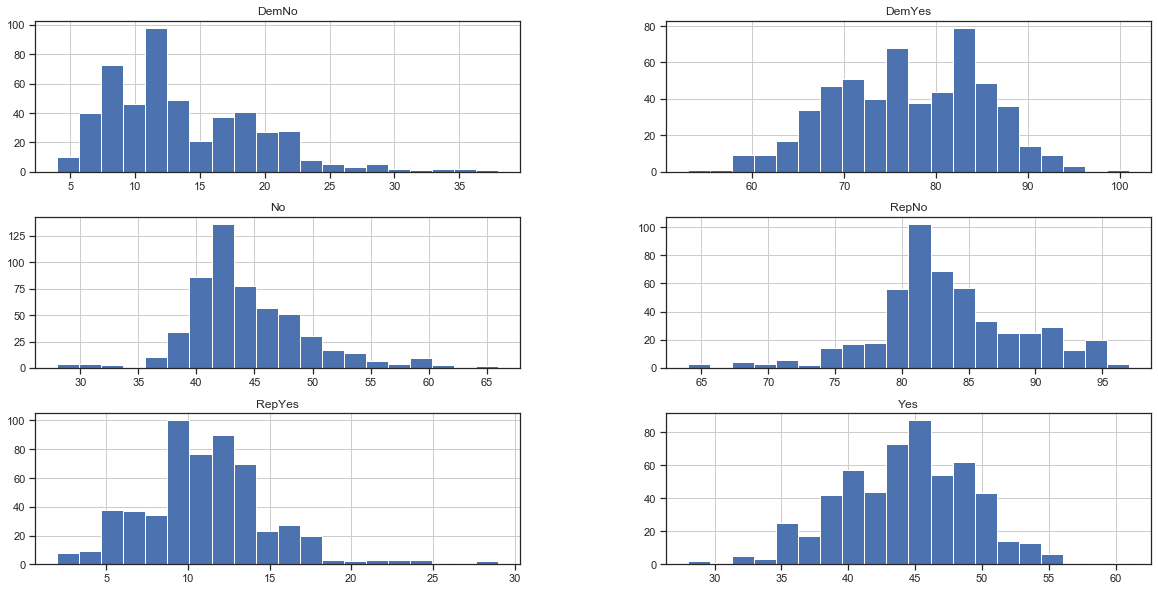

In [60]:
# histogram
hist = data_sub.hist(bins=20, figsize=(20,10))

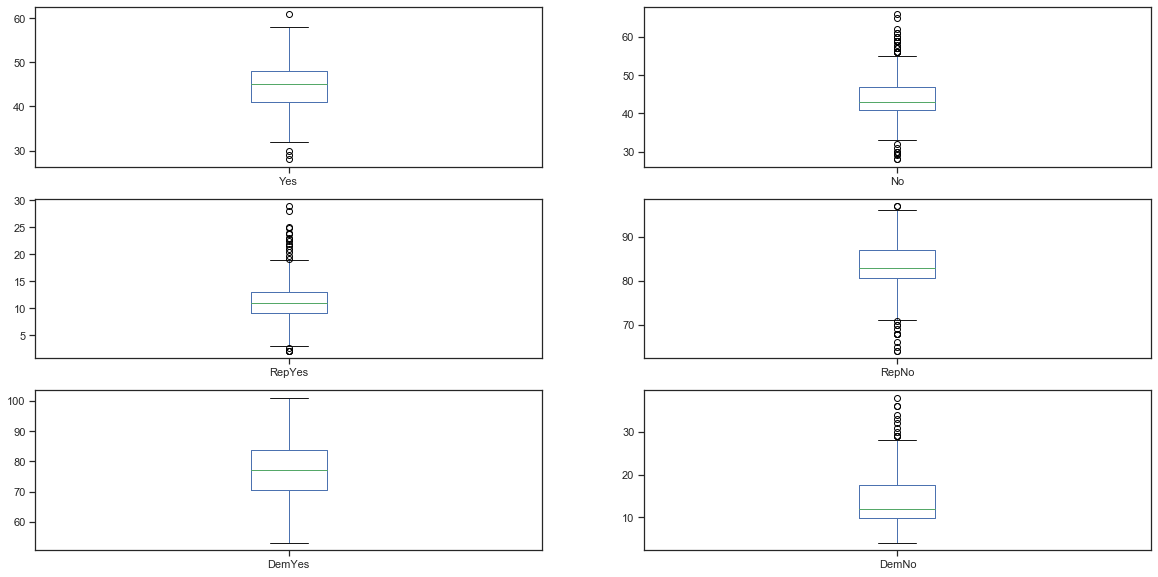

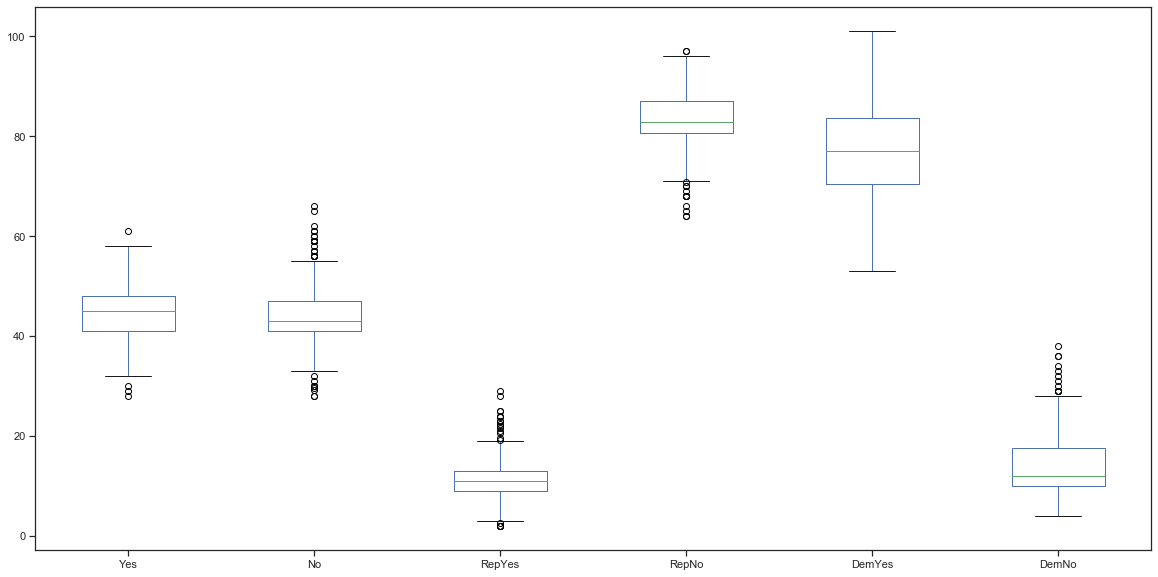

In [61]:
# box plot
box = data_sub.plot(kind='box', subplots=True, layout=(3,2),sharex=False,sharey=False, figsize=(20,10))
box1= data_sub.plot(kind='box', subplots=False, layout=(2,3), sharex=False, sharey=False, figsize=(20,10))

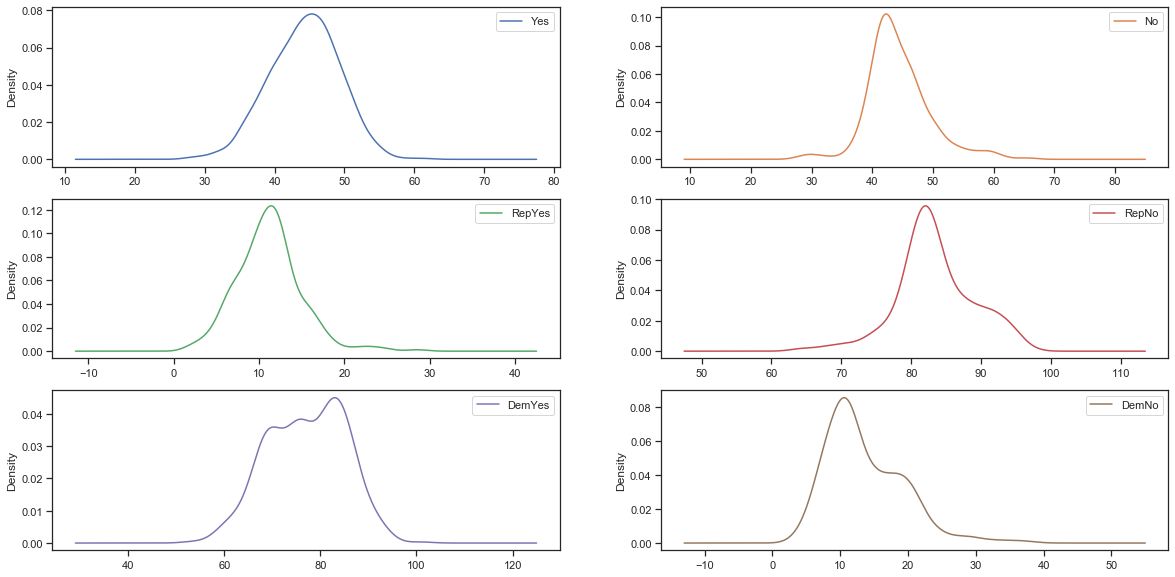

In [62]:
# density plot
dens = data_sub.plot(kind='density', subplots=True, layout=(3,2), sharex=False, sharey=False,figsize=(20,10))

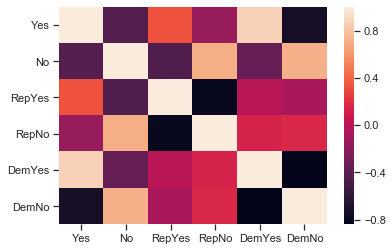

In [14]:
# correlation heat map
corr = data_sub.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels = corr.columns.values)

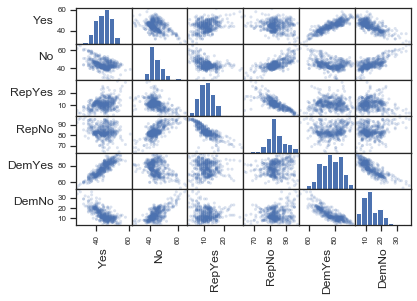

In [15]:
# pandas scatter_matrix
ocor_a = pd.plotting.scatter_matrix(data_sub, alpha = 0.2)
for i in ocor_a.flatten():
    i.xaxis.label.set_rotation(90)
    i.yaxis.label.set_rotation(0)
    i.yaxis.label.set_ha('right')

In [16]:
# data imputation on RepYes columns using Linear Regression
# checking correlation between Yes and RepYes to see if can be used for LR
core_p = ('Correlation: ', data_sub['Yes'].corr(data_sub['RepYes']))
print(*core_p)

Correlation:  0.33313947958677836


In [17]:
# to split training and testing subsests will make a filter to avoid NaN values on RepYes
df_filter = data_sub[data_sub['RepYes']>=0].copy()
print(df_filter.shape)

(517, 6)


In [18]:
# creating objects to house predictions and real values
y_pred = []
y_true = []

In [63]:
# using k-fold validation for the model using 10 folds.
kf = KFold(n_splits=10, random_state = 42)
for train_index, test_index in kf.split(df_filter):
    df_test = df_filter.iloc[test_index]
    df_train = df_filter.iloc[train_index]
# defining input and output.    
    x_train = np.array(df_train['Yes']).reshape(-1,1)
    y_train = np.array(df_train['RepYes']).reshape(-1,1)
    x_test = np.array(df_test['Yes']).reshape(-1,1)
    y_test = np.array(df_test['RepYes']).reshape(-1,1)
# fiting LR model.  
    model = LinearRegression()
    model.fit(x_train, y_train)
# generating/appending prediction values to the objects created before    
    y_pred.append(model.predict(x_test)[0])
    y_true.append(y_test[0])  

In [20]:
# checking performance of model with mean square error
print(len(y_pred))
print(len(y_true))
print('Mean Square Error: ', mean_squared_error(y_true, y_pred))

10
10
Mean Square Error:  9.655229260740445


In [21]:
# creating list with NaN values on RepYes to be used in the model
df_missing = data_sub[data_sub['RepYes'].isnull()].copy()  

In [65]:
# predicting NaN values on RepYes with the model for NaN values
x_test_lr = np.array(df_missing['Yes']).reshape(-1,1)
y_test_lr = np.array(df_missing['RepYes']).reshape(-1,1)

x_train_lr = np.array(df_filter['Yes']).reshape(-1,1)
y_train_lr = np.array(df_filter['RepYes']).reshape(-1,1)

In [24]:
# creating LR object
model_lr = LinearRegression()

In [25]:
# fiting LR model
model_lr.fit(x_train_lr, y_train_lr)
print('Linear regression predictions: ', model_lr.predict(x_test_lr)[0])

Linear regression predictions:  [9.2239262]


In [27]:
# store prediction result in a variable
pred = model_lr.predict(x_test_lr)

In [29]:
# crating variable with RepYes values to imput predicted values in NaN psitions
repyes_vals = data_sub['RepYes'].values

In [30]:
# loop to imput values on RepYes NaN with predicted values
i_value = 0
for i in range(len(repyes_vals)):
    if np.isnan(repyes_vals[i]):
        repyes_vals[i] = pred[i_value]
        i_value += 1

In [31]:
# copiando values from variable to RepYes column
data_sub['RepYes'] = repyes_vals

In [68]:
# plot outputs
#plt.scatter(x_test_lr, y_test_lr,  color='black') #scatter will not work because the 'y' was NaN  
#plt.plot(x_test_lr, pred, color='blue', linewidth=3)

In [33]:
# data imputation on DemYes columns using Linear Regression
# checking correlation between Yes and RepYes to see if can be used for LR
print('Correlation: ', data_sub['Yes'].corr(data_sub['DemYes']))

Correlation:  0.8749763678243391


In [34]:
# to split training and testing subsests will make a filter to avoid NaN values on RepYes
df_filter = data_sub[data_sub['DemYes']>=0].copy()
print(df_filter.shape)

(523, 6)


In [35]:
# creating objects to house predictions and real values
y_pred = []
y_true = []

In [36]:
# using k-fold validation for the model using 10 folds.
kf = KFold(n_splits=10, random_state = 42)
for train_index, test_index in kf.split(df_filter):
    df_test = df_filter.iloc[test_index]
    df_train = df_filter.iloc[train_index]
# defining input and output.    
    x_train = np.array(df_train['Yes']).reshape(-1,1)
    y_train = np.array(df_train['DemYes']).reshape(-1,1)
    x_test = np.array(df_test['Yes']).reshape(-1,1)
    y_test = np.array(df_test['DemYes']).reshape(-1,1)
# fiting LR model.  
    model = LinearRegression()
    model.fit(x_train, y_train)
# generating/appending prediction values to the objects created before    
    y_pred.append(model.predict(x_test)[0])
    y_true.append(y_test[0])  

In [37]:
# checking performance of model with mean square error
print(len(y_pred))
print(len(y_true))
print('Mean Square Error: ', mean_squared_error(y_true, y_pred))

10
10
Mean Square Error:  15.953709449188173


In [38]:
# creating list with NaN values on RepYes to be used in the model
df_missing = data_sub[data_sub['DemYes'].isnull()].copy()   

In [40]:
# predicting NaN values on RepYes with the model for NaN values
x_test_lr = np.array(df_missing['Yes']).reshape(-1,1)

x_train_lr = np.array(df_filter['Yes']).reshape(-1,1)
y_train_lr = np.array(df_filter['DemYes']).reshape(-1,1)

In [41]:
# creating LR object
model_lr = LinearRegression()

In [42]:
# fiting LR model
model_lr.fit(x_train_lr, y_train_lr)
print('Linear regression predictions: ', model_lr.predict(x_test_lr)[0])

Linear regression predictions:  [68.10481426]


In [44]:
# store prediction result in a variable
pred = model_lr.predict(x_test_lr)

In [46]:
# crating variable with RepYes values to imput predicted values in NaN psitions
repyes_vals = data_sub['DemYes'].values

In [47]:
# loop to imput values on RepYes NaN with predicted values
i_value = 0
for i in range(len(repyes_vals)):
    if np.isnan(repyes_vals[i]):
        repyes_vals[i] = pred[i_value]
        i_value += 1

In [48]:
# copiando values from variable to RepYes column
data_sub['DemYes'] = repyes_vals  

In [69]:
# plot outputs
#plt.scatter(x_test, y_test,  color='black')
#plt.plot(x_test, pred, color='blue', linewidth=3)

In [50]:
# Multivariate Linear Regression to predict Yes

# creating different dataframe with columns to be used as target and variables
df = pd.DataFrame(data_sub, columns=['Yes','RepYes','DemYes'])

In [51]:
# creating 'x' and 'y' objects to be used into the Multiple Linear Regression
x = pd.DataFrame(df, columns=['RepYes','DemYes'])
y = pd.DataFrame(df, columns=['Yes'])

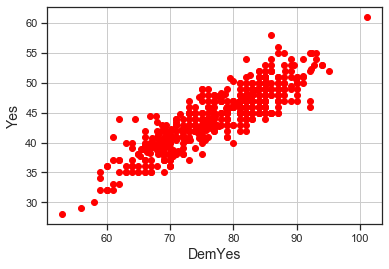

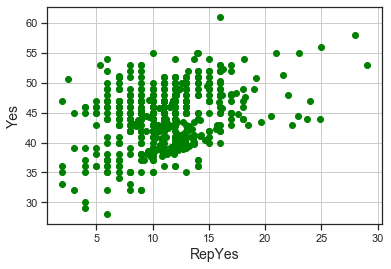

In [52]:
# ploting to see linear relationship 
plt.scatter(df['DemYes'], df['Yes'], color='red')
plt.xlabel('DemYes', fontsize=14)
plt.ylabel('Yes', fontsize=14)
plt.grid(True)
plt.show()

plt.scatter(df['RepYes'], df['Yes'], color='green')
plt.xlabel('RepYes', fontsize=14)
plt.ylabel('Yes', fontsize=14)
plt.grid(True)
plt.show()

In [53]:
# spliting database
k2 = int(len(df['Yes']) * 0.2) # 20% samples
k8 = int(len(df['Yes']) * -0.8) # 80% samples

x_train = x[k8:] #80%
x_train = np.c_[np.ones(len(x_train),dtype='int64'),x_train]
y_train = y[k8:]

x_test = x[:k2] #20%
x_test = np.c_[np.ones(len(x_test),dtype='int64'),x_test]
y_test = y[:k2]
y_test = y_test.round(0)

In [54]:
# creating LR object
model_mr = LinearRegression()

In [55]:
# fiting LR model
model_mr.fit(x_train, y_train)
print('multi linear regression predictions: ', model_mr.predict(x_test)[0])

multi linear regression predictions:  [33.78166857]


In [56]:
# store prediction result in a variable
pred = model_mr.predict(x_test)
pred = pred.round(0)

In [57]:
# verifying accuracy
# coefficients
print('Coefficients: \n', model_mr.coef_)
# mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, pred))
# variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, pred))

Coefficients: 
 [[0.         0.40688594 0.54404073]]
Mean squared error: 3.13
Variance score: 0.82


In [58]:
# prepare model data point for visualization
pred_f = pred.flatten()
pred_df = pd.DataFrame({'Predict_Yes':pred_f})

dfk = pd.concat([y_test, pred_df], axis=1)

error = dfk['Yes'] - dfk['Predict_Yes']

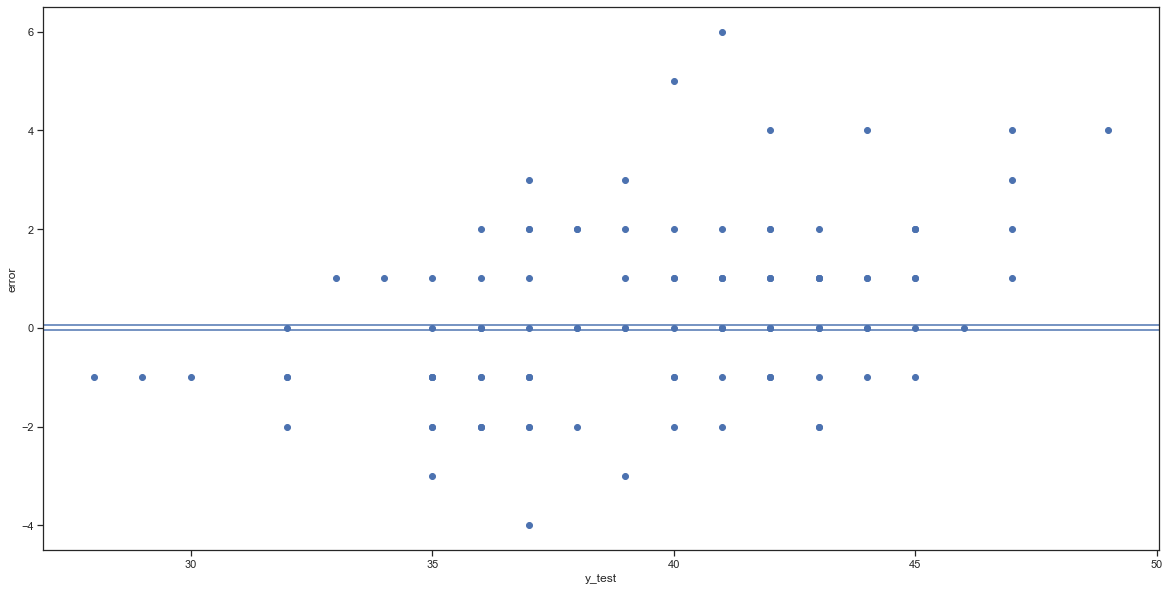

In [59]:
# plot error
plt.figure(figsize = (20,10))
plt.scatter(y_test,error)
plt.axhline(0.05)
plt.axhline(-0.05)
plt.xlabel('y_test')
plt.ylabel('error')
plt.show()